In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import line_profiler

import datetime

from io import StringIO
from pandas.api.types import CategoricalDtype

import pandas._testing as tm

## returns df from string data
def g(data):
    return pd.read_csv(StringIO(data))

In [4]:
df = pd.read_csv('te.csv')
df

,Multi,Single
0,[[20]|[yes]],[35|50]


In [13]:
d="""text
Emerging evidence that Mexico economy was back...
Chrysler Corp Tuesday announced million in new...
CompuServe Corp Tuesday reported surprisingly ...
CompuServe Corp Tuesday reported surprisingly ...
If dining at Planet Hollywood made you feel li...
Hog prices fell Tuesday after government slaug...
Blue chip stocks rallied Tuesday after the Fed...
Sprint Corp Tuesday announced plans to offer I...
Shoppers are loading up this year on perennial...
Kansas and Arizona filed lawsuits against some..."""
df=pd.read_csv(StringIO(d))
df

,text
0,Emerging evidence that Mexico economy was back...
1,Chrysler Corp Tuesday announced million in new...
2,CompuServe Corp Tuesday reported surprisingly ...
3,CompuServe Corp Tuesday reported surprisingly ...
4,If dining at Planet Hollywood made you feel li...
5,Hog prices fell Tuesday after government slaug...
6,Blue chip stocks rallied Tuesday after the Fed...
7,Sprint Corp Tuesday announced plans to offer I...
8,Shoppers are loading up this year on perennial...
9,Kansas and Arizona filed lawsuits against some...


In [14]:
n=7 # replace it with 250
df[df['text'].str.split().str.len() > n]

,text
4,If dining at Planet Hollywood made you feel li...
6,Blue chip stocks rallied Tuesday after the Fed...
7,Sprint Corp Tuesday announced plans to offer I...
8,Shoppers are loading up this year on perennial...


In [16]:
df['len'] = df['text'].str.split().str.len()
df

,text,len
0,Emerging evidence that Mexico economy was back...,7
1,Chrysler Corp Tuesday announced million in new...,7
2,CompuServe Corp Tuesday reported surprisingly ...,6
3,CompuServe Corp Tuesday reported surprisingly ...,6
4,If dining at Planet Hollywood made you feel li...,9
5,Hog prices fell Tuesday after government slaug...,7
6,Blue chip stocks rallied Tuesday after the Fed...,8
7,Sprint Corp Tuesday announced plans to offer I...,8
8,Shoppers are loading up this year on perennial...,8
9,Kansas and Arizona filed lawsuits against some...,7


In [78]:
df = pd.DataFrame({'Index': ['0', '0', '1', '1'], 'Title': ["CEO", "VP", "CEO", "VP"], 'Compensation': ['125000', '100000', '0', '0'] })


In [80]:
df.Compensation=df.Compensation.astype(int)
df.groupby('Index')['Compensation'].idxmax()

Index
0    0
1    2
Name: Compensation, dtype: int64

In [81]:
df = pd.DataFrame( [[0, 5], [-1, 0], [1, 2]], columns = ["test1", "test2"]) 
df

,test1,test2
0,0,5
1,-1,0
2,1,2


<AxesSubplot:xlabel='variable', ylabel='value'>

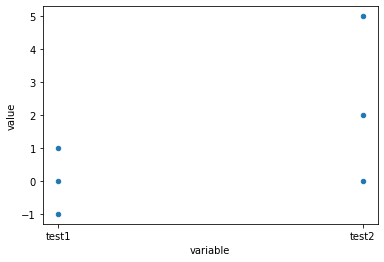

In [84]:
df.melt().plot(kind='scatter', x='variable', y='value')

In [141]:
d="""Column_A
11.2 some text 17 some text 21
some text 25.2 4.1 some text 53 17 78
121.1 bla bla bla 14 some text
12 some text"""
df = g(d)
df

,Column_A
0,11.2 some text 17 some text 21
1,some text 25.2 4.1 some text 53 17 78
2,121.1 bla bla bla 14 some text
3,12 some text


In [147]:
listA, listB, listC, listD = df.Column_A.str.findall(r"[-+]?\d*\.\d+|\d+")


['11.2', '17', '21']

In [94]:
listA=list()
listA[0] = 11.2
listA[1] = 17
listA[2] = 21
listA

IndexError: list assignment index out of range

In [128]:
import pandas as pd
import numpy as np
d = {'fruit': ['apple', 'pear', 'peach'] * 5, 'values': np.random.randint(0,1000,15)}
df = pd.DataFrame(data=d)

d2 = {'fruit': ['apple', 'pear', 'peach'], 'min': np.random.randint(0,1000,3), 'max': np.random.randint(0,1000,3)}
df2 = pd.DataFrame(data=d2)
df

,fruit,values
0,apple,296
1,pear,362
2,peach,823
3,apple,883
4,pear,753
5,peach,280
6,apple,805
7,pear,871
8,peach,937
9,apple,932


In [129]:
df2

,fruit,min,max
0,apple,467,947
1,pear,894,646
2,peach,307,618


In [140]:
df3 = df.merge(df2, on='fruit', how='inner')
df3 = df3.loc[(df3['min'] < df3['values']) & (df3['max'] > df3['values'])]
df3

,fruit,values,min,max
1,apple,883,467,947
2,apple,805,467,947
3,apple,932,467,947
4,apple,665,467,947
13,peach,331,307,618


In [136]:
df3 = df3.drop(columns=['min', 'max'])
df3

,fruit,values
3,apple,883
6,apple,805
9,apple,932
11,peach,331
12,apple,665


In [150]:
df = pd.DataFrame({'id': [12, 35, 37, 67, 99, 78],
                  'product': ['banana', 'apple', 'banana', 'pear', 'banana', 'apple'],
                  'reordered': [1, 0, 0, 1, 1, 1]})
df

,id,product,reordered
0,12,banana,1
1,35,apple,0
2,37,banana,0
3,67,pear,1
4,99,banana,1
5,78,apple,1


In [152]:
pd.crosstab(df['product'], df['reordered']).add_prefix('reordered_')\
   .assign(count=lambda x: x.sum(1))\
   .reset_index()

reordered,product,reordered_0,reordered_1,count
0,apple,1,1,2
1,banana,1,2,3
2,pear,0,1,1


In [178]:
d = """Name,Date,Time
A,02/20/2021,12:30:06
A,02/20/2021,12:30:20
A,02/21/2021,12:30:20
A,02/22/2021,02:30:30"""
df=g(d)
df
for i in range(17):
    df = pd.concat([df,df])
df.shape
f = lambda x: '' if pd.isna(x) else f'{int(x)} seconds'

In [179]:
%timeit pd.to_datetime(df.Date + ' ' + df.Time).diff().dt.total_seconds().transform(f)

742 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [180]:
%timeit pd.to_datetime(df.Date + ' ' + df.Time).diff().dt.total_seconds().map(f)

731 ms ± 8.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [181]:
%timeit pd.to_datetime(df.Date + ' ' + df.Time).diff().dt.total_seconds().apply(f)

761 ms ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [192]:
d = """INDEX,MATHS,SCORE
1,Student1,44
2,Student2,35
3,Student3,36"""
df1 = g(d)
df1

,INDEX,MATHS,SCORE
0,1,Student1,44
1,2,Student2,35
2,3,Student3,36


In [193]:
df1[['INDEX', 'SUBJECT']] = [3, 'Maths']
df1

,INDEX,MATHS,SCORE,SUBJECT
0,3,Student1,44,Maths
1,3,Student2,35,Maths
2,3,Student3,36,Maths


In [185]:
d="""INDEX,SUBJECT,SCORE
1,English,50
2,Science,37
1,English,36
2,Science,44"""
df2=g(d)
df2

,INDEX,SUBJECT,SCORE
0,1,English,50
1,2,Science,37
2,1,English,36
3,2,Science,44


In [200]:
df3 = pd.concat([df1, df2]).drop(columns='MATHS')


,INDEX,SCORE,SUBJECT
0,3,44,Maths
1,3,35,Maths
2,3,36,Maths
0,1,50,English
1,2,37,Science
2,1,36,English
3,2,44,Science


In [207]:
df3.groupby(pd.Categorical(df3.SUBJECT,
            categories=['English','Science', 'Maths'], 
                           ordered=True)).groups

{'English': [0, 2], 'Science': [1, 3], 'Maths': [0, 1, 2]}

In [225]:
d="""IDBILL,IDBUYER,BILL,DATE
001,768787,45,1897-07-24
002,768787,30,1897-07-24
005,786545,45,1897-08-19
008,657676,89,1989-09-23
009,657676,42,1989-09-23
010,657676,18,1989-09-23
012,657676,51,1990-03-10
016,892354,73,1990-03-10
018,892354,48,1765-02-14"""
df=g(d)
df

,IDBILL,IDBUYER,BILL,DATE
0,1,768787,45,1897-07-24
1,2,768787,30,1897-07-24
2,5,786545,45,1897-08-19
3,8,657676,89,1989-09-23
4,9,657676,42,1989-09-23
5,10,657676,18,1989-09-23
6,12,657676,51,1990-03-10
7,16,892354,73,1990-03-10
8,18,892354,48,1765-02-14


In [226]:
df['DATE'] = pd.to_datetime(df.DATE)
df

,IDBILL,IDBUYER,BILL,DATE
0,1,768787,45,1897-07-24
1,2,768787,30,1897-07-24
2,5,786545,45,1897-08-19
3,8,657676,89,1989-09-23
4,9,657676,42,1989-09-23
5,10,657676,18,1989-09-23
6,12,657676,51,1990-03-10
7,16,892354,73,1990-03-10
8,18,892354,48,1765-02-14


In [227]:
df['DATE'] = pd.to_datetime(df.DATE)
df = df.groupby(['DATE', 'IDBUYER'], sort=False)[['IDBILL','BILL']].min().reset_index()
df

,DATE,IDBUYER,IDBILL,BILL
0,1897-07-24,768787,1,30
1,1897-08-19,786545,5,45
2,1989-09-23,657676,8,18
3,1990-03-10,657676,12,51
4,1990-03-10,892354,16,73
5,1765-02-14,892354,18,48


In [235]:
data = pd.DataFrame({'county': {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I'}, 'new_covid_19_cases_per_100k': {0: 9.89857311398793, 1: 8.96808587445497, 2: 10.4018656786281, 3: 5.44259755461725, 4: 8.47402557487262, 5: 8.23708135804402, 6: 21.1781816000959, 7: 6.34201242466493, 8: 11.9630512616746, 9: 14.0, 10: 16.3, 11: 13.1, 12: 9.3, 13: 11.0, 14: 12.6, 15: 20.9, 16: 8.2, 17: 13.6}, 'new_covid_19_hospitalizations': {0: 0.735745284982339, 1: 0.681120446161137, 2: 1.07219230841243, 3: 0.118317338143853, 4: 0.526882419163064, 5: 0.599666185823225, 6: 1.07095735019448, 7: 0.141985352791006, 8: 0.854503661548189, 9: 0.9, 10: 0.8, 11: 1.5, 12: 0.2, 13: 0.5, 14: 0.8, 15: 0.9, 16: 0.1, 17: 0.7}, 'reporting_period': {0: '10/04/2020 - 10/17/2020', 1: '10/04/2020 - 10/17/2020', 2: '10/04/2020 - 10/17/2020', 3: '10/04/2020 - 10/17/2020', 4: '10/04/2020 - 10/17/2020', 5: '10/04/2020 - 10/17/2020', 6: '10/04/2020 - 10/17/2020', 7: '10/04/2020 - 10/17/2020', 8: '10/04/2020 - 10/17/2020', 9: '10/11/2020 - 10/24/2020', 10: '10/11/2020 - 10/24/2020', 11: '10/11/2020 - 10/24/2020', 12: '10/11/2020 - 10/24/2020', 13: '10/11/2020 - 10/24/2020', 14: '10/11/2020 - 10/24/2020', 15: '10/11/2020 - 10/24/2020', 16: '10/11/2020 - 10/24/2020', 17: '10/11/2020 - 10/24/2020'}, 'date': {0: '2020-10-22T00:00:00', 1: '2020-10-22T00:00:00', 2: '2020-10-22T00:00:00', 3: '2020-10-22T00:00:00', 4: '2020-10-22T00:00:00', 5: '2020-10-22T00:00:00', 6: '2020-10-22T00:00:00', 7: '2020-10-22T00:00:00', 8: '2020-10-22T00:00:00', 9: '2020-10-29T00:00:00', 10: '2020-10-29T00:00:00', 11: '2020-10-29T00:00:00', 12: '2020-10-29T00:00:00', 13: '2020-10-29T00:00:00', 14: '2020-10-29T00:00:00', 15: '2020-10-29T00:00:00', 16: '2020-10-29T00:00:00', 17: '2020-10-29T00:00:00'}}) 
data.head(3)

,county,new_covid_19_cases_per_100k,new_covid_19_hospitalizations,reporting_period,date
0,A,9.898573,0.735745,10/04/2020 - 10/17/2020,2020-10-22T00:00:00
1,B,8.968086,0.681120,10/04/2020 - 10/17/2020,2020-10-22T00:00:00
2,C,10.401866,1.072192,10/04/2020 - 10/17/2020,2020-10-22T00:00:00


In [236]:
data['date'] = pd.to_datetime(data.date)
data = data.set_index(['reporting_period', 'date'])
data.head(2)

county  new_covid_19_cases_per_100k  \
reporting_period        date                                             
10/04/2020 - 10/17/2020 2020-10-22      A                     9.898573   
                        2020-10-22      B                     8.968086   

                                    new_covid_19_hospitalizations  
reporting_period        date                                       
10/04/2020 - 10/17/2020 2020-10-22                       0.735745  
                        2020-10-22                       0.681120

In [253]:

data =[['Name','john','riya','alex'],
       ['Age',28, 24, 34],[ 'Month','February','January','March'],
       ['Status','M','F','M']] 

df = pd.DataFrame(data,columns=['index',0,0,0])
df1 = df.set_index('index')
df1

,0,0,0
index,,,
Name,john,riya,alex
Age,28,24,34
Month,February,January,March
Status,M,F,M


In [238]:
desired_data = {'January' :pd.Series(['riya', 24, 'F'], index=['Name', 'Age','Status']),
                'February':  pd.Series(['john', 28, 'M'], index=['Name', 'Age','Status']),
                'March' : pd.Series(['alex', 34, 'M'], index=['Name', 'Age','Status'])}

df2 = pd.DataFrame(desired_data)
df2

,January,February,March
Name,riya,john,alex
Age,24,28,34
Status,F,M,M


In [254]:
df1.columns = df1.iloc[2]
df1 = df1.drop(df1.index[2])
df2 = df1.rename_axis(None).rename_axis(None,axis='columns')
df2

,February,January,March
Name,john,riya,alex
Age,28,24,34
Status,M,F,M


In [260]:
df = pd.DataFrame({
    'flag': {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1}
})

# Create Group IDs based on where 0s are
groups = df.flag.eq(0).cumsum()

# Groupby groups and transform each group to the size
#df['Count'] = df.groupby(groups)['flag'].transform('size')
#df


0    NaN
1    1.0
2    0.0
3    0.0
4    0.0
5   -1.0
6    0.0
7    1.0
8    0.0
9    0.0
dtype: float64

In [262]:
d="""IDBILL,IDBUYER,BILL,DATE
001,768787,45,1897-07-24
001,768787,67,1897-07-24
001,768787,98,1897-07-24
002,768787,30,1897-07-24
002,768787,15,1897-07-24
002,768787,12,1897-07-24
005,786545,45,1897-08-19
008,657676,89,1989-09-23
009,657676,42,1989-09-23
010,657676,18,1989-09-23
012,657676,51,1990-03-10
016,892354,73,1990-03-10
018,892354,48,1765-02-14
020,892354,62,1765-02-14"""
df=g(d)
df.DATE = pd.to_datetime(df.DATE)
df

,IDBILL,IDBUYER,BILL,DATE
0,1,768787,45,1897-07-24
1,1,768787,67,1897-07-24
2,1,768787,98,1897-07-24
3,2,768787,30,1897-07-24
4,2,768787,15,1897-07-24
5,2,768787,12,1897-07-24
6,5,786545,45,1897-08-19
7,8,657676,89,1989-09-23
8,9,657676,42,1989-09-23
9,10,657676,18,1989-09-23


In [263]:
df.groupby(['IDBUYER','DATE'],as_index=False, 
           sort=False)[['IDBILL','BILL']].min()

,IDBUYER,DATE,IDBILL,BILL
0,768787,1897-07-24,1,12
1,786545,1897-08-19,5,45
2,657676,1989-09-23,8,18
3,657676,1990-03-10,12,51
4,892354,1990-03-10,16,73
5,892354,1765-02-14,18,48


In [268]:
d="""Aerogenerador,Cause,DateOn,DateOFF
A0201,Windturbine Pause,02/01/2021 10:00,02/01/2021 10:05
A0202,Windturbine STOP,02/01/2021 10:00,02/01/2021 10:05
A0202,High Temperature DE,02/01/2021 10:00,02/01/2021 10:05"""
df=g(d)
df

,Aerogenerador,Cause,DateOn,DateOFF
0,A0201,Windturbine Pause,02/01/2021 10:00,02/01/2021 10:05
1,A0202,Windturbine STOP,02/01/2021 10:00,02/01/2021 10:05
2,A0202,High Temperature DE,02/01/2021 10:00,02/01/2021 10:05


In [269]:
df = df.query('Cause not in ["Windturbine Pause", "Windturbine STOP"]')
df

,Aerogenerador,Cause,DateOn,DateOFF
2,A0202,High Temperature DE,02/01/2021 10:00,02/01/2021 10:05


In [272]:
df[~df.Cause.str.contains("Windturbine")]

,Aerogenerador,Cause,DateOn,DateOFF
2,A0202,High Temperature DE,02/01/2021 10:00,02/01/2021 10:05


In [11]:
import re
name = 'AbcBBCTestVariable'
name = re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()
print(name)  # camel_case_name

abc_b_b_c_test_variable


In [16]:
data = {'Patient_admitted_id': [214321,224323,3234234,23423],
        'Date':  ['2021-01-22', '2021-01-22','2021-01-22','2021-01-20'], # This is just an example I have created here, the real X data frame contains proper date values generated with Datatime
        'Hospital_ID': ['1', '2','3','2'],
        }
X = pd.DataFrame(data, columns=['Patient_admitted_id','Date', 'Hospital_ID' ])
X

,Patient_admitted_id,Date,Hospital_ID
0,214321,2021-01-22,1
1,224323,2021-01-22,2
2,3234234,2021-01-22,3
3,23423,2021-01-20,2


In [19]:
X['Date']= pd.to_datetime(X['Date'])
df = X.groupby(pd.Grouper(key='Date', freq='D')).size().reset_index(name='Cases')       
df['Cumulative'] = df.Cases.cumsum()    
df

,Date,Cases,Cumulative
0,2021-01-20,1,1
1,2021-01-21,0,1
2,2021-01-22,3,4
